In [1]:
# package management

import streamlit as st
import pandas as pd
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pytesseract

In [ ]:
## fetch frames from videos

import cv2
vidcap = cv2.VideoCapture('HACKATHON VIDEOS COR 2022/AVI/995/2W/AVI/2018-06-28-16-30-35_2018-04-30-12-43-12_1.avi')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("imgs/995/SAX_2w/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

In [3]:
## number recognition! *does not work for our photos with this kind of quality
BGR = cv2.imread('tt1.png')
RGB = cv2.cvtColor(BGR, cv2.COLOR_BGR2RGB)

lower = np.array([175, 125, 45], dtype="uint8")
upper = np.array([255, 255, 255], dtype="uint8")

mask = cv2.inRange(RGB, lower, upper)
img = cv2.bitwise_and(RGB, RGB, mask=mask)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray = 255 - gray
emp = np.full_like(gray, 255)
emp -= gray

emp[emp==0] = 255
emp[emp<100] = 0

gauss = cv2.GaussianBlur(emp, (3,3), 1)
gauss[gauss<220] = 0

text = pytesseract.image_to_string(gauss, config='outputbase digits')

print(text)

True

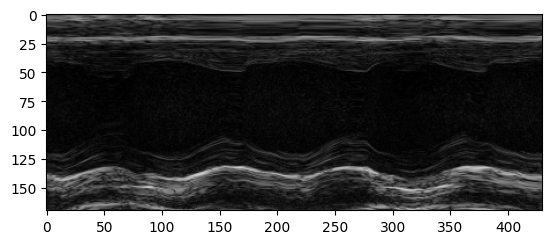

In [46]:
## Cut image 
path = "imgs/995/PSLA_2w/"
path_cut = "imgs/995/PSLA_2w_cut/"
img1 = cv2.imread(path+'frame21.jpg')
img2 = cv2.imread(path+'frame42.jpg')
# img3 = cv2.imread(path+'frame63.jpg')
# cropped_image3 = img3[ 215:385,21:451]
# img4 = cv2.imread(path+'frame84.jpg')
# cropped_image4 = img4[ 215:385,21:451]
# img5 = cv2.imread(path+'frame106.jpg')
# cropped_image5 = img5[ 215:385,21:451]
#print(img1.shape) # Print image shape
#cv2.imshow("original", img1)

# Cropping an image
cropped_image = img1[ 215:385,21:451]
cropped_image2 = img2[ 215:385,21:451]
#print(cropped_image)
 
# Display cropped image
# cv2.imshow("cropped", cropped_image)
 
plt.imshow(cropped_image)
# Save the cropped image
cv2.imwrite(path_cut+"frame21.jpg", cropped_image)
cv2.imwrite(path_cut+"frame42.jpg", cropped_image2)
# cv2.imwrite(path_cut+"frame63.jpg", cropped_image3)
# cv2.imwrite(path_cut+"frame84.jpg", cropped_image4)
# cv2.imwrite(path_cut+"frame106.jpg", cropped_image5)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [2]:
#Preprocess the image for measurements
def process(path, thresh_medium, thresh_higher, thresh_lower, h):
    
	img_org= cv2.imread(path)
	
	#Denoising techniques 
	img_org = cv2.fastNlMeansDenoisingColored(img_org,None,20,20,14,22)
	plt.imshow(img_org, cmap="gray")

	img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)

	kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
 
 	# lower part of LVID
	img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
	ret1,thresh1 = cv2.threshold(img,thresh_medium,255,cv2.THRESH_BINARY)
	mask_rec = np.ones(thresh1.shape[:2], dtype="uint8") * 255
	cv2.rectangle(mask_rec, (0,0),(thresh1.shape[:2][1],h),0,-1)
	masked = cv2.bitwise_and(thresh1,thresh1,mask= mask_rec)
	#print(masked)
	#plt.imshow(masked, cmap="gray")
	#implot1 = plt.imshow(255-thresh1, cmap='gray')
	plt.imsave('./res/medium.png', 255-masked, cmap = 'gray')
 
	# higher part of LVID
	ret2,thresh2 = cv2.threshold(img,thresh_higher,255,cv2.THRESH_BINARY)
	contours, hierarchy  = cv2.findContours(thresh2,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)      
	contours = sorted(contours, key=cv2.contourArea)
	counter = 0
	#plt.imshow(thresh2, cmap="gray")
	# check for area of each contour and only save with the biggest one
	for c in contours:
		area = cv2.contourArea(c)
		if (area > 10000):
			counter+=1
	l = [-x for x in range(1,counter+1)]
	countors_req = [contours[i] for i in l]
	mask1 = np.ones(thresh1.shape[:2], dtype="uint8") * 255
	cv2.fillPoly(mask1, pts = countors_req, color=(0,0,0))
	#implot = plt.imshow(255-mask1, cmap='gray')
	#implot2 = plt.imshow(255-thresh2, cmap='gray')
	plt.imsave('./res/higher.png', 255-mask1, cmap = 'gray')
 

	# measure for LVPW
	ret3,thresh3 = cv2.threshold(img,thresh_lower,255,cv2.THRESH_BINARY)
	#implot3 = plt.imshow(thresh3, cmap='gray')
	mask_rec = np.ones(thresh3.shape[:2], dtype="uint8") * 255
	cv2.rectangle(mask_rec, (0,0),(thresh1.shape[:2][1],h),0,-1)
	masked = cv2.bitwise_and(thresh3,thresh3,mask= mask_rec)
	contours, hierarchy  = cv2.findContours(masked,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)            
	contours = sorted(contours, key=cv2.contourArea)            
	mask2 = np.ones(thresh1.shape[:2], dtype="uint8") * 255
	cv2.drawContours(mask2, contours[-1], -1, 0, -1)
	cv2.fillPoly(mask2, pts =[contours[-1]], color=(0,0,0))
	#img4 = cv2.bitwise_and(thresh3, img, mask=mask2)
	#implot = plt.imshow(255-mask2, cmap='gray')
	plt.imsave('./res/lower.png', mask2, cmap = 'gray')        

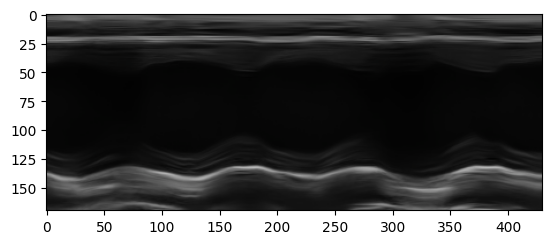

In [13]:
# recomend values for procees funciton
# 25,15,60,250

#process(path, medium, higher, lower )
process('imgs/995/PSLA_2w_cut/frame63.jpg',17,10,60,80)
# process('test_image2.png',20,20,60,50)
